In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torch.utils.data import sampler
import torchvision.datasets as dset
import torchvision.transforms as T
import os
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/My Drive/{}'.format('fluidproject/'))

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from unet_parts import *
from unet_model import UNet
import numpy as np

In [ ]:
device =torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
stldata = np.load('/content/drive/MyDrive/fluidproject/stlsave.npy')
xdata = np.load('/content/drive/MyDrive/fluidproject/xsave.npy').astype(int)
vdata = np.load('/content/drive/MyDrive/fluidproject/vsave.npy')
ydata = np.load('/content/drive/MyDrive/fluidproject/ysave.npy')
stldata = torch.tensor(stldata)
xdata = torch.tensor(xdata)
vdata = torch.tensor(vdata)
ydata = torch.tensor(ydata)

In [ ]:
stldata_v = np.load('/content/drive/MyDrive/fluidproject/stlsave_v.npy')
xdata_v = np.load('/content/drive/MyDrive/fluidproject/xsave_v.npy').astype(int)
vdata_v = np.load('/content/drive/MyDrive/fluidproject/vsave_v.npy')
ydata_v = np.load('/content/drive/MyDrive/fluidproject/ysave_v.npy')
stldata_v = torch.tensor(stldata_v)
xdata_v = torch.tensor(xdata_v)
vdata_v = torch.tensor(vdata_v)
ydata_v = torch.tensor(ydata_v)

In [ ]:
print(stldata.shape)
print(xdata.shape)
print(vdata.shape)
print(ydata.shape)

torch.Size([12, 1, 300, 300])
torch.Size([75, 1, 1, 1])
torch.Size([75, 1, 1, 1])
torch.Size([75, 1, 300, 300])


In [ ]:
stldata = (stldata-150)/150

In [ ]:
print(torch.min(stldata),torch.max(stldata))

tensor(-1.) tensor(1.)


In [ ]:
def masked_mse(x,pred,y):
  mse=torch.square(y-pred)
  mse[x!=torch.max(x)]=0
  return mse

def train(model,
          device,
          dataset_n,
          epochs: int = 5,
          batch_size: int = 1,
          learning_rate: float = 1e-5,
          val_percent: float = 0.,
          weight_decay: float = 1e-8,
          momentum: float = 0.999,
          amp: bool = False,
          gradient_clipping: float = 1.0,):
  global loss_save

  n_val = int(dataset_n * val_percent)
  n_train = dataset_n - n_val
  train_i, val_i = random_split(torch.arange(dataset_n), [n_train, n_val])
  loader_args = dict(batch_size=10, num_workers=os.cpu_count(), pin_memory=True)
  train_i_loader = DataLoader(train_i, shuffle=True, **loader_args)
  val_i_loader = DataLoader(val_i, shuffle=False, drop_last=True, **loader_args)


  optimizer = optim.RMSprop(model.parameters(),
                            lr=learning_rate,
                            weight_decay=weight_decay,
                            momentum=momentum,
                            foreach=True)

  grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
  model = model.to(device)
  for epoch in range(1, epochs + 1):
    model.train()
    epoch_loss = 0

    for x in train_i_loader:
      x_data = torch.squeeze(stldata[xdata[x,:,0,0]],1)
      v_data = vdata[x]
      y_data = ydata[x]

      x_data = x_data.to(device)
      v_data = v_data.to(device)
      y_data = y_data.to(device)
      with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
        pred = model(x_data,v_data)
        loss = torch.mean(masked_mse(x_data, pred, y_data))

      optimizer.zero_grad(set_to_none=True)
      grad_scaler.scale(loss).backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), gradient_clipping)
      grad_scaler.step(optimizer)
      grad_scaler.update()


      epoch_loss += loss.item()
    if epoch %100 == 0:
      print(f'epochs: {epoch}, loss: {epoch_loss}')

In [ ]:
unet = UNet(1,1)


In [ ]:
#unet Load
unet.load_state_dict(torch.load('/content/drive/MyDrive/fluidproject/unet_state_dict3_3.pt'))

<All keys matched successfully>

In [ ]:
loss_save = []

In [ ]:
train(unet,device, 75, batch_size= 32, epochs = 500, learning_rate = 5e-7)

epochs: 100, loss: 12.538782775402069
epochs: 200, loss: 10.696668088436127
epochs: 300, loss: 10.852291703224182
epochs: 400, loss: 11.278776109218597
epochs: 500, loss: 11.469419121742249


In [ ]:
len(loss_save)

0

In [ ]:
torch.save(unet.state_dict(), 'unet_state_dict3_3.pt')

In [ ]:
def pred_b(x,pred,y):
  pred[x!=torch.max(x)]=0
  return pred

def test_diff(model, x_data, v_data, y_data):
  model = model.to(torch.device('cpu'))
  with torch.no_grad():
    pred = model(x_data,v_data)
    pred_ = pred_b(x_data, pred, y_data)
    abs_ = torch.abs(y_data - pred_)
  return pred_, abs_


In [ ]:
dataidx = 67

x_test = torch.squeeze(stldata[xdata[dataidx,:,0,0]],1).reshape((1,1,300,300))
v_test = vdata[dataidx].reshape((1,1,1,1))
y_test = ydata[dataidx].reshape((1,1,300,300))

In [ ]:
pred, mae = test_diff(unet,x_test,v_test,y_test)

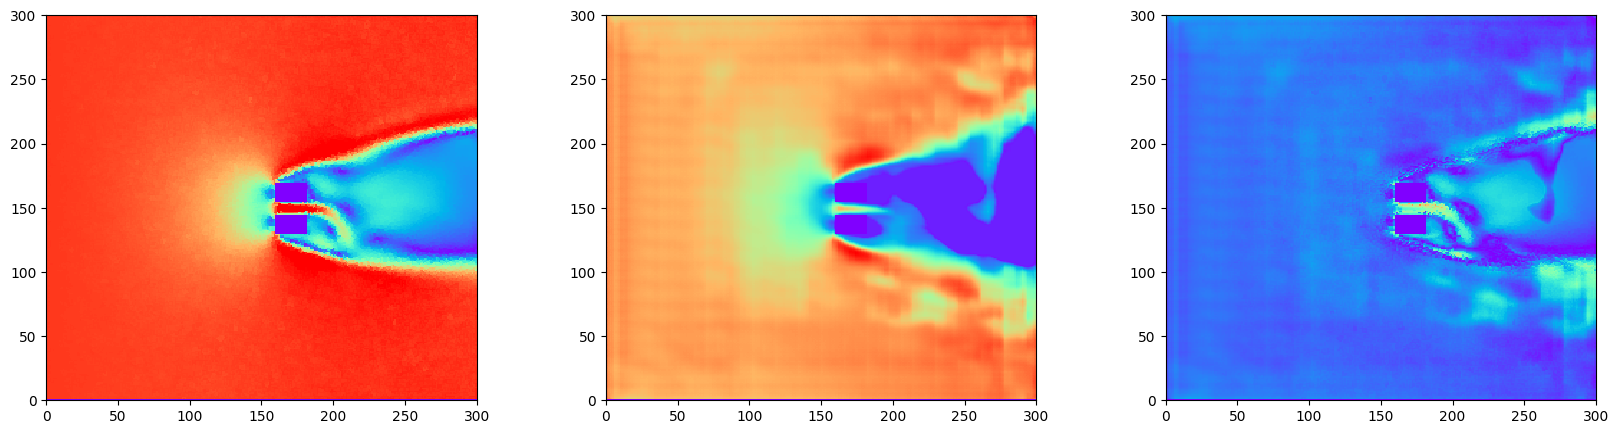

In [ ]:
f, axes = plt.subplots(1,3)
f.set_size_inches((20, 5))
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)
sctt_1 = axes[0].pcolor(y_test[0][0],cmap='rainbow')
sctt_2 = axes[1].pcolor(pred[0][0],cmap='rainbow')
sctt_3 = axes[2].pcolor(mae[0][0],cmap='rainbow')

max_ = torch.max(pred[0][0])
sctt_1.set_clim(0, max_)
sctt_2.set_clim(0, max_)
sctt_3.set_clim(0, max_)

In [ ]:
validx = 2

x_test_v = torch.squeeze(stldata_v[xdata_v[validx,:,0,0]],1).reshape((1,1,300,300))
v_test_v = vdata_v[validx].reshape((1,1,1,1))
y_test_v = ydata_v[validx].reshape((1,1,300,300))

In [ ]:
pred_v, mae_v = test_diff(unet,x_test_v,v_test_v,y_test_v)

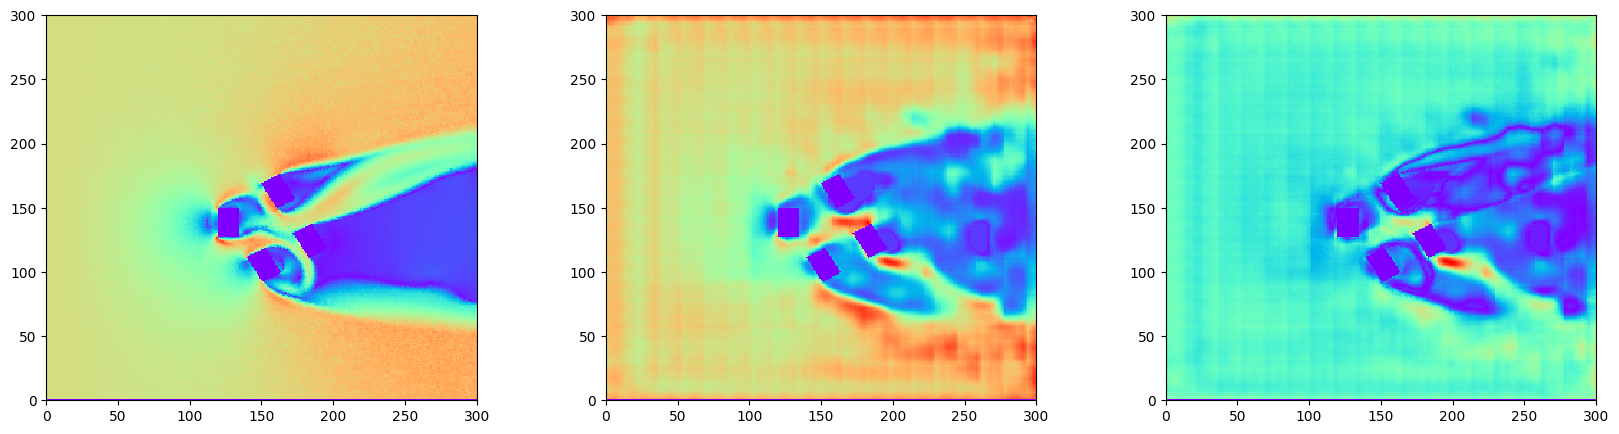

In [ ]:
f, axes = plt.subplots(1,3)
f.set_size_inches((20, 5))
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)
sctt_1 = axes[0].pcolor(y_test_v[0][0],cmap='rainbow')
sctt_2 = axes[1].pcolor(pred_v[0][0],cmap='rainbow')
sctt_3 = axes[2].pcolor(mae_v[0][0],cmap='rainbow')


In [ ]:
print(torch.mean(mae_v))

tensor(5.7883)


In [ ]:
range_1_y = 6
range_1_v = 12

range_2_y = 15
range_2_v = 30

In [ ]:
print(torch.max(pred_v[0][0]))

tensor(16.6095)


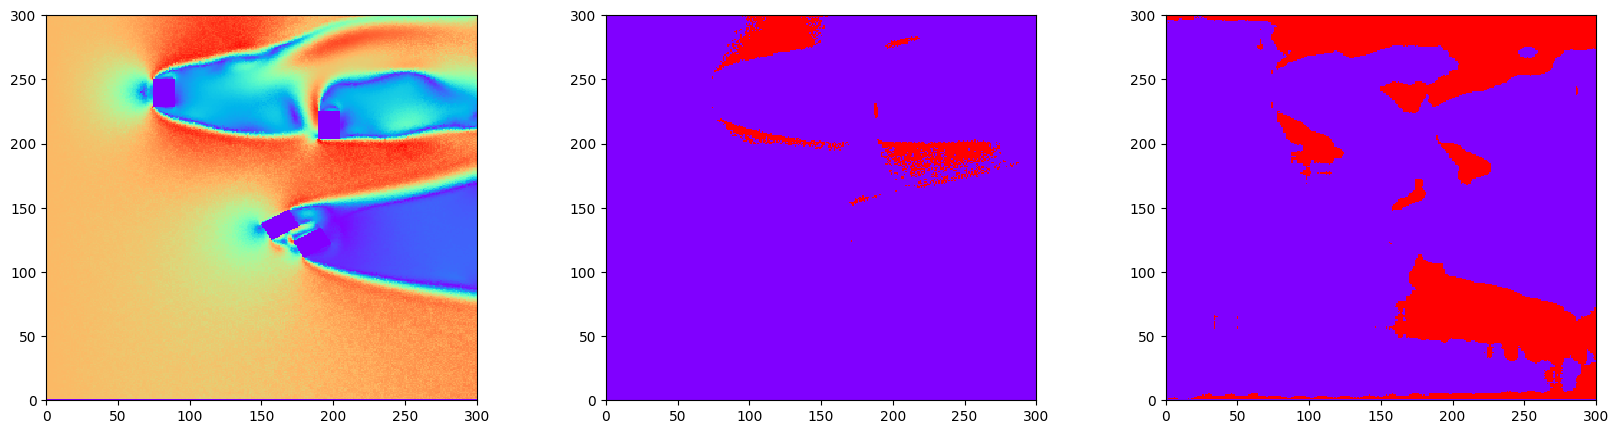

In [ ]:
y_test_v_fence = torch.zeros_like(y_test_v)
y_test_v_fence[y_test_v>=range_1_y]=1
y_test_v_fence[y_test_v>=range_2_y]=2
pred_v_fence = torch.zeros_like(pred_v)
pred_v_fence[pred_v>=range_1_v]=1
pred_v_fence[pred_v>=range_2_v]=2

f, axes = plt.subplots(1,3)
f.set_size_inches((20, 5))
plt.subplots_adjust(wspace = 0.3, hspace = 0.3)
sctt_1 = axes[0].pcolor(y_test_v[0][0],cmap='rainbow')
sctt_2 = axes[1].pcolor(y_test_v_fence[0][0],cmap='rainbow')
sctt_3 = axes[2].pcolor(pred_v_fence[0][0],cmap='rainbow')

max_= 1
sctt_2.set_clim(0, max_)
sctt_3.set_clim(0, max_)


In [ ]:
starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
repetitions = 10
timings=np.zeros((repetitions,1))
data_n = 20

dummy_x = torch.zeros([data_n,1,300,300])
dummy_v = torch.zeros([data_n,1,1,1])


# MEASURE PERFORMANCE
with torch.no_grad():
    for rep in range(repetitions):
        starter.record()
        _ = unet(dummy_x,dummy_v)
        ender.record()
        torch.cuda.synchronize()
        curr_time = starter.elapsed_time(ender)
        timings[rep] = curr_time

In [ ]:
np.mean(timings)

6412.62890625

In [ ]:
!nvidia-smi

Mon Jun 19 20:21:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    27W /  70W |   3023MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------